# Spectral Clustering
---
Spectral clustering for link prediction:
1. Compute eigendecomposition of graph Laplacian
2. Take top K eigenvectors --> node embedding vectors (Z)
3. Edge scores = sigmoid(Z * Z^T)
3. Test scores these scores against actual edge values (ROC AUC, AP)

Scikit-learn documentation: http://scikit-learn.org/stable/modules/generated/sklearn.manifold.spectral_embedding.html

## 1. Read in Graph Data

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import scipy.sparse as sp
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

In [2]:
EDGES_DIR = 'facebook/0.edges'

# Read edge-list
f = open(EDGES_DIR)
g_orig = nx.read_edgelist(f, nodetype=int)
g_adj = nx.to_numpy_matrix(g_orig) # convert to adjacency matrix (so node values become indices)
g = nx.from_numpy_matrix(g_adj) # re-create graph using node indices (0 to num_nodes-1)

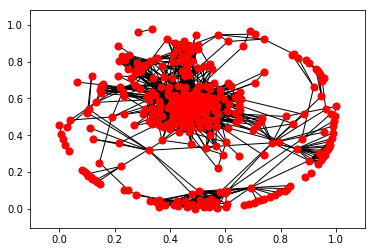

In [3]:
# draw network
nx.draw_networkx(g_orig, with_labels=False, node_size=50, node_color='r')
plt.show()

## 2. Preprocessing/Train-Test Split

In [4]:
from gae.preprocessing import mask_test_edges
np.random.seed(0) # make sure train-test split is consistent between notebooks
adj_sparse = nx.to_scipy_sparse_matrix(g)

# Perform train-test split
adj_train, train_edges, train_edges_false, val_edges, val_edges_false, \
    test_edges, test_edges_false = mask_test_edges(adj_sparse, test_frac=.3, val_frac=.1)
g_train = nx.from_scipy_sparse_matrix(adj_train) # new graph object with only non-hidden edges

In [5]:
# Inspect train/test split
print "Total nodes:", adj_sparse.shape[0]
print "Total edges:", int(adj_sparse.nnz/2) # adj is symmetric, so nnz (num non-zero) = 2*num_edges
print "Training edges (positive):", len(train_edges)
print "Training edges (negative):", len(train_edges_false)
print "Validation edges (positive):", len(val_edges)
print "Validation edges (negative):", len(val_edges_false)
print "Test edges (positive):", len(test_edges)
print "Test edges (negative):", len(test_edges_false)

Total nodes: 333
Total edges: 2519
Training edges (positive): 1513
Validation edges (positive): 251
Validation edges (negative): 251
Test edges (positive): 755
Test edges (negative): 755


In [6]:
def get_roc_score(edges_pos, edges_neg, embeddings):
    score_matrix = np.dot(embeddings, embeddings.T)
    
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    
    # Store positive edge predictions, actual values
    preds_pos = []
    pos = []
    for edge in edges_pos:
        preds_pos.append(sigmoid(score_matrix[edge[0], edge[1]])) # predicted score
        pos.append(adj_sparse[edge[0], edge[1]]) # actual value (1 for positive)
        
    # Store negative edge predictions, actual values
    preds_neg = []
    neg = []
    for edge in edges_neg:
        preds_neg.append(sigmoid(score_matrix[edge[0], edge[1]])) # predicted score
        neg.append(adj_sparse[edge[0], edge[1]]) # actual value (0 for negative)
        
    # Calculate scores
    preds_all = np.hstack([preds_pos, preds_neg])
    labels_all = np.hstack([np.ones(len(preds_pos)), np.zeros(len(preds_neg))])
    roc_score = roc_auc_score(labels_all, preds_all)
    ap_score = average_precision_score(labels_all, preds_all)
    return roc_score, ap_score

## 3. Spectral Clustering

In [7]:
from sklearn.manifold import spectral_embedding

# Get spectral embeddings (16-dim)
emb = spectral_embedding(adj_train, n_components=16, random_state=0)

/Users/lucashu/anaconda/envs/gae/lib/python2.7/site-packages/sklearn/manifold/spectral_embedding_.py:229: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


In [8]:
# Calculate ROC AUC and Average Precision
sc_roc, sc_ap = get_roc_score(test_edges, test_edges_false, emb)

print 'Spectral Clustering Test ROC score: ', str(sc_roc)
print 'Spectral Clustering Test AP score: ', str(sc_ap)

Spectral Clustering Test ROC score:  0.906504100697
Spectral Clustering Test AP score:  0.896759799718
